### Example notebook for connecting to a SparkCluster over a Docker Network
#### Client is Driver
#### SparkCluster is outside the client container (in other container)

Francisco Humeres M.

Example on how to submit jobs to a Spark Cluster from a Driver App (client) not located in the same host as the Spark Cluster (from example a separate Docker Container, or a VM in other location).

## Context
* Spark hast three basic components:
    - The **Driver** program, which submits jobs and interacts with the Cluster Manager.
    - The **Cluster Manager**, that manages the executor instances on different nodes. This is an external service that interfaces with Spark (i.e. Mesos, YARN).
    - The **Executors** instances on each node (a JVM process), that run tasks assigned by the Cluster Manager, and keep data in memory or disk storage across them. The executors run the tasks on multiple threads inside the nodes.
* If using PySpark, RDD's and variables are serialized in the Driver, and later handled by Scala Spark code in the Cluster Manager and Executors.
* The results (data) are stored in **Executors instances**, which transfer them **directly** to the **Driver**. For this reason, **Executors and Driver** need to be **network reachable** (i.e. Executors need access to Driver).
* This is not a problem in Stand Alone mode (Cluster deamons running on a same machine or host). However, if **Driver** and **the Spark Cluster** are on different machines (or VM, or hosts), **Executors need to be told how to reach back the Driver**. Here is shown a solution through dynamically changing configuration parameters on a Python IDE, which are going to reach the Executors **through the Job Submit**.
* Important is to ensure that **Driver** and **Spark Cluster** have installed the **same versions** of Spark-Hadoop binding, OJDK (and maybe Scala). See:
    - https://community.cloudera.com/t5/Support-Questions/Spark-Standalone-error-local-class-incompatible-stream/td-p/25909

* **Refs**:
    - https://community.cloudera.com/t5/Support-Questions/Initial-job-has-not-accepted-any-resources-whereas-resources/td-p/128281
    - https://coderedirect.com/questions/345550/running-spark-driver-program-in-docker-container-no-connection-back-from-execu
    - http://site.clairvoyantsoft.com/understanding-resource-allocation-configurations-spark-application/
    - https://spark.apache.org/docs/latest/spark-standalone.html
    - https://stackoverflow.com/questions/45489248/running-spark-driver-program-in-docker-container-no-connection-back-from-execu

![]()

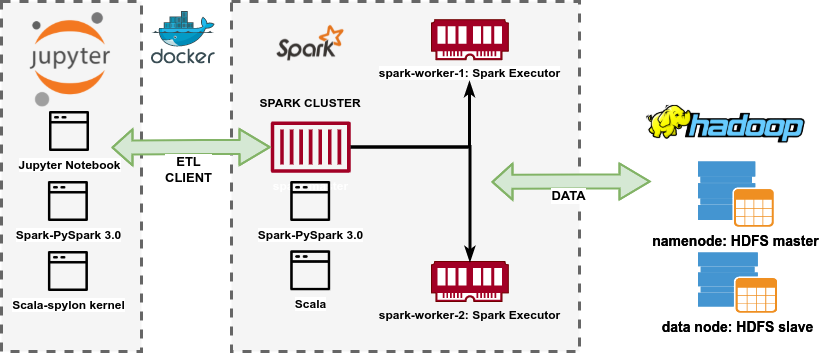

In [5]:
from IPython.display import Image
Image(filename="/data/driver-master-spark.png")

In [2]:
import pyspark

#Set configurations in SparkContext. This will basically tell the Executors, through information encoded in the Job Submit,
#how to reach back the Driver client.
pyspark.SparkContext.setSystemProperty('spark.executor.memory', '6g') #assign Memory to each executor
#Bind IP adress inside the Driver container (through which IP it will communicate with the network)
pyspark.SparkContext.setSystemProperty('spark.driver.bindAddress', '0.0.0.0')
#THIS IS IMPORTANT: IP or name of the Driver on the network, that will be visible by Executors. 
#Basically we are telling executors how to find Driver in the Job Submit.
pyspark.SparkContext.setSystemProperty('spark.driver.host', 'jupyter')
pyspark.SparkContext.setSystemProperty('spark.driver.port', '7001') #Port through which executors can access Driver.
pyspark.SparkContext.setSystemProperty('spark.driver.blockManager.port', '15003') #Block Manager port.
pyspark.SparkContext.setSystemProperty('spark.port.maxRetries', '10') #Retries for communication attempts.

21/12/11 03:51:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
#Spark Context, master=Where to find the SparkMaster (which deals with the Cluster Manager)
sc = pyspark.SparkContext(master="spark://spark-master:7077", appName="maps_and_lazy_evaluation_example")

In [4]:
#convert Spar Context to SQLContext to test reading a CSV file
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [6]:
#Test reading a Csv file
brewfile = sqlContext.read.csv("hdfs://namenode:9000/data/openbeer/breweries/breweries.csv").limit(20)

In [7]:
brewfile.show()

+----+--------------------+-------------+-----+---+
| _c0|                 _c1|          _c2|  _c3|_c4|
+----+--------------------+-------------+-----+---+
|null|                name|         city|state| id|
|   0|  NorthGate Brewing |  Minneapolis|   MN|  0|
|   1|Against the Grain...|   Louisville|   KY|  1|
|   2|Jack's Abby Craft...|   Framingham|   MA|  2|
|   3|Mike Hess Brewing...|    San Diego|   CA|  3|
|   4|Fort Point Beer C...|San Francisco|   CA|  4|
|   5|COAST Brewing Com...|   Charleston|   SC|  5|
|   6|Great Divide Brew...|       Denver|   CO|  6|
|   7|    Tapistry Brewing|     Bridgman|   MI|  7|
|   8|    Big Lake Brewing|      Holland|   MI|  8|
|   9|The Mitten Brewin...| Grand Rapids|   MI|  9|
|  10|      Brewery Vivant| Grand Rapids|   MI| 10|
|  11|    Petoskey Brewing|     Petoskey|   MI| 11|
|  12|  Blackrocks Brewery|    Marquette|   MI| 12|
|  13|Perrin Brewing Co...|Comstock Park|   MI| 13|
|  14|Witch's Hat Brewi...|   South Lyon|   MI| 14|
|  15|Founde